# OCT-SOX Insert

Take post D2 models, and peaks open exclusively in D2 ("neural-like"). Insert canonical OCT-SOX motifs and see increase in predicted counts.

In [1]:
import numpy as np
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
from modisco.visualization import viz_sequence
import pyBigWig

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [2]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [3]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [20]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx4/extra_models/P2qbCl.h5")

    model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx2/2021-04-14_18_11_26/Dp2D6w.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
    model_neur = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx5/2021-04-14_18_11_26/nqv4wJ.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx8/2021-04-14_18_11_26/HhcfZk.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx1/2021-04-14_18_11_26/89fam2.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx14/2021-04-15_09_22_38/Y4lI6R.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/2021-04-15_09_33_42/7zunw4.h5")

In [5]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [6]:
oct_sox_hits = pd.read_csv("./data/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.200.OCTSOX.thresh7.bed", 
                           sep='\t',
                           names=["chr", "start", "end", "strand", "score", "seq"])
oct_sox_hits.head()

,chr,start,end,strand,score,seq
0,chr1,2350165,2350180,+,7.492762,CTTTGAATATAAAAT
1,chr1,5940748,5940763,+,8.132912,ATCTACATTTTAAAA
2,chr1,7263287,7263302,-,12.820701,CTTTCTTTTGCAAAT
3,chr1,7843523,7843538,-,7.100240,TTTTGTTTTTAAAAT
4,chr1,9756154,9756169,-,7.883148,ATTTCACATGAAAAT


In [7]:
first_seq = oct_sox_hits.iloc[0]
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]

>chr1:2350166-2350180
CTTTGAATATAAAAT

In [8]:
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]==first_seq['seq']

True

In [9]:
oct_sox_hits.shape

(5032, 6)

In [10]:
MODEL_INP_LEN = model.input_shape[0][1]
MODEL_OUT_LEN = model.output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

2346
2000


In [11]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


In [12]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 - (mid-r['start'])
        motif_end = MODEL_INP_LEN//2 + (r['end']-mid)
        # make sure seqs match
        assert(cur_raw_seqs[-1][motif_start:motif_end] == r['seq'])
        
        # replace with canonical (or something else)
        # OCTSOX: ATTTGCATAACAATG/CATTGTTATGCAAAT
        # OCTonly: ATTTGCATAAAAGAC/GTCTTTTATGCAAAT
        # KLF:  GCCACACCCAAGGAG/CTCCTTGGGTGTGGC
        # random: ACGTAGAATACTGTG
        # random: ATATATATATATATAT
        if r['strand'] == "+":
            replacement = "ATTTGCATAACAATG"
        else:
            replacement = "CATTGTTATGCAAAT"
        
        cur_raw_seqs[-1] = cur_raw_seqs[-1][:motif_start] +  replacement + cur_raw_seqs[-1][motif_end:] 
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()

100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


In [13]:
np.median(raw_pred_counts)

4.7102566

In [14]:
np.median(synth_pred_counts)

5.649965

In [15]:
np.median(np.exp(synth_pred_counts-raw_pred_counts))

2.464294

In [16]:
np.median(synth_pred_counts-raw_pred_counts)

0.9019053

In [21]:
scipy.stats.ttest_rel(raw_pred_counts, synth_pred_counts)

Ttest_relResult(statistic=14.762073793478283, pvalue=2.6044797393420606e-48)

<AxesSubplot:>

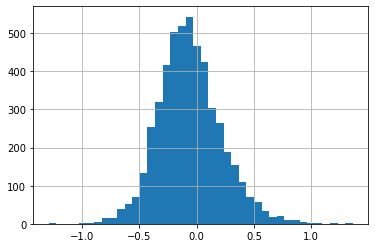

In [218]:
plt.rcParams["figure.figsize"] = (6,4)

pd.Series(synth_pred_counts-  raw_pred_counts).hist(bins=40)

Text(0, 0.5, 'A (on removing ZEB motif)')

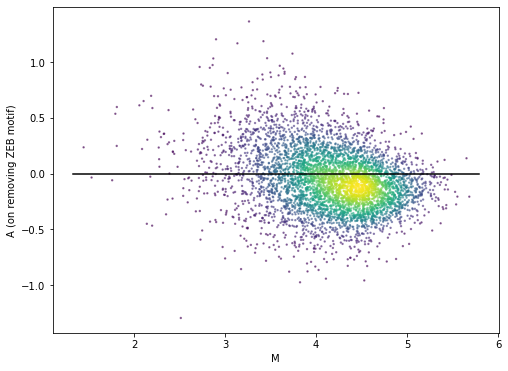

In [23]:
plt.rcParams["figure.figsize"] = (8,6)

x = (raw_pred_counts+synth_pred_counts)/2
y = (synth_pred_counts-raw_pred_counts)
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
plt.plot([min(raw_pred_counts), max(raw_pred_counts)], [0,0], '-k', label='y=2x+1')
plt.xlabel("M")
plt.ylabel("A (on removing ZEB motif)")
# plt.savefig("image.jpg", dpi=300)

### Locus Level

In [1]:
synth_pred_counts[:20]

NameError: name 'synth_pred_counts' is not defined

In [52]:
raw_pred_counts[:20]

array([4.969944 , 4.174495 , 4.1261373, 4.6758313, 4.1133447, 3.7510118,
       3.540275 , 4.012049 , 5.0419517, 4.974635 , 4.950492 , 5.089274 ,
       3.627579 , 5.36136  , 4.4437103, 2.9317954, 3.4936674, 4.009578 ,
       4.9822288, 4.5243773], dtype=float32)

In [125]:
def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

In [33]:
import pyBigWig

In [34]:
f = pyBigWig.open("/oak/stanford/groups/akundaje/surag/projects//scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx4.bw")

In [339]:
# f.close()

In [87]:
from copy import deepcopy
import scipy

In [183]:
(7924304+7924689)//2

7924496

In [199]:
chosen_hit = oct_sox_hits.iloc[4]

chosen_hit = {"start": 7789280, "chr":"chr18"}
# {"start": 70552562, "chr":"chr8"} neural specific peak
# {"start": 7789280, "chr":"chr12"} NANOG prom centered at OS motif

midpt = chosen_hit["start"]
origseq = str(hg38[chosen_hit["chr"]][midpt-(MODEL_INP_LEN//2):midpt+(MODEL_INP_LEN//2)])

In [200]:
idx1 = (MODEL_INP_LEN//2)

In [201]:
len(origseq)

2346

In [202]:
origseq[idx1:idx1+15]

'TGCCACTGCACTCCA'

In [203]:
alt1seq = origseq[:idx1] + "TTTTGCATTACAATG" + origseq[idx1+15:]
alt2seq = origseq[:idx1] + "ATTTGCATAACAATG" + origseq[idx1+15:]
alt3seq = origseq[:idx1] + "ATATATATATATATA" + origseq[idx1+15:] 
# "ATTTGCATAACAATG/CATTGTTATGCAAAT"
# "ATATATATATATATA"

In [204]:
cur_raw_seqs = one_hot.dna_to_one_hot([origseq, alt1seq, alt2seq,alt3seq])

In [229]:
prof, cts = model.predict([cur_raw_seqs, 
               np.zeros((cur_raw_seqs.shape[0],1)), 
               np.zeros((cur_raw_seqs.shape[0],2000,2))])

In [230]:
cts

array([[4.014119 ],
       [3.909163 ],
       [3.8984687],
       [3.898752 ]], dtype=float32)

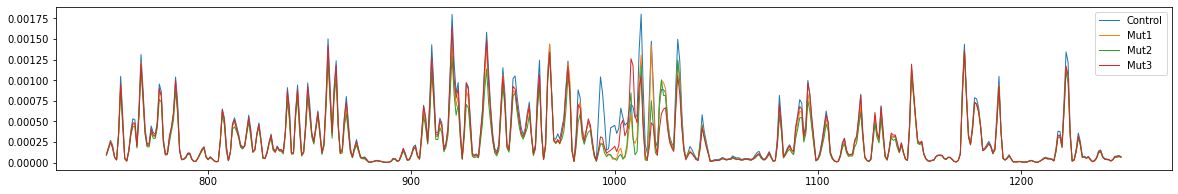

In [207]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1]))[750:1250], linewidth=1, label="Mut1")
plt.plot(range(2000)[750:1250], (softmax(prof[2]))[750:1250], linewidth=1, label="Mut2")
plt.plot(range(2000)[750:1250], (softmax(prof[3]))[750:1250], linewidth=1, label="Mut3")
# plt.plot(range(2000)[750:1250], (softmax(prof[5]))[750:1250], linewidth=1, label="All Mut")
plt.legend()

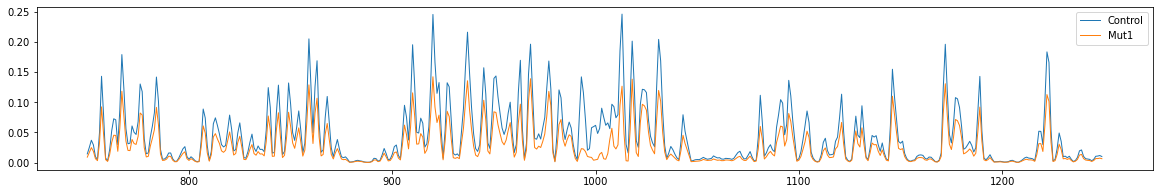

In [208]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0])*np.exp(cts[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1])*np.exp(cts[1]))[750:1250], linewidth=1, label="Mut1")
plt.legend()

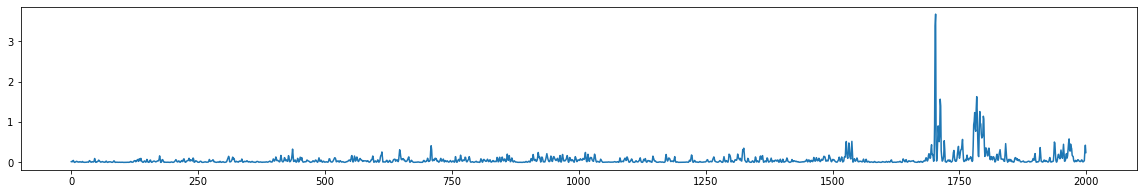

In [209]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[0])*np.exp(cts[0]))

In [194]:
np.sum(np.nan_to_num(f.values(chosen_hit["chr"], midpt - 1000, midpt+1000)))

114.0

[<matplotlib.lines.Line2D at 0x7f75265b4dd0>]

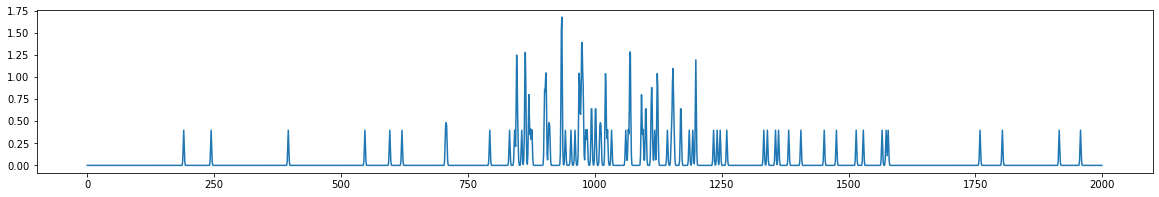

In [195]:
plt.rcParams["figure.figsize"] = (20,3)
smoothed_observed = scipy.ndimage.gaussian_filter1d(np.nan_to_num(f.values(chosen_hit["chr"], midpt - 1000, midpt+1000)), 1)
plt.plot(range(2000), smoothed_observed)

In [38]:
from shaputils import *
import shap

In [393]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model)

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[1]],
         tf.reduce_sum(model.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[2]], weightedsum_meannormed_logits),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

weightedsum_meannormed_logits_neur = get_weightedsum_meannormed_logits(model_neur)

profile_model_counts_explainer_neur = shap.explainers.deep.TFDeepExplainer(
        ([model_neur.input[0], model_neur.input[1]],
         tf.reduce_sum(model_neur.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer_neur = shap.explainers.deep.TFDeepExplainer(
        ([model_neur.input[0], model_neur.input[2]], weightedsum_meannormed_logits_neur),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

In [232]:
X = cur_raw_seqs
counts_shap_scores = profile_model_counts_explainer.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores = np.multiply(X, counts_shap_scores[0])

Done 0 examples of 4


In [233]:
# profile_shap_scores = profile_model_profile_explainer.shap_values(
#         [X, np.zeros((X.shape[0], 2000, 2))], progress_message=100)
# projected_shap_scores = np.multiply(X, profile_shap_scores[0])

In [234]:
from modisco.visualization import viz_sequence

TypeError: plot_weights_given_ax() got an unexpected keyword argument 'ylimits'

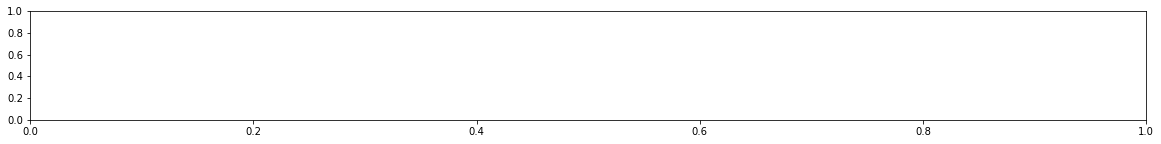

In [221]:
viz_sequence.plot_weights(projected_shap_scores[0][1023:1323], subticks_frequency=50)

(-0.06, 0.02)

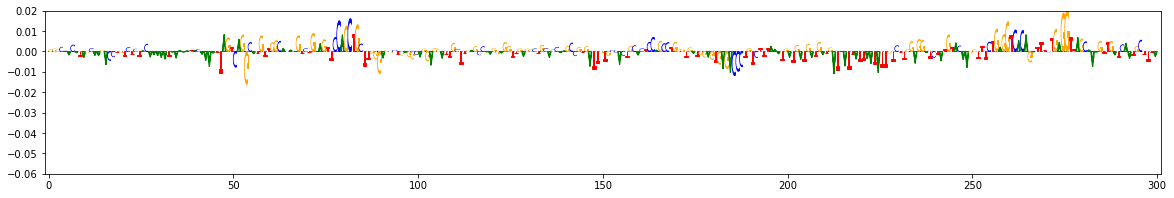

In [235]:
fig, ax= plt.subplots()
viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[0][1023:1323], subticks_frequency=50)
ax.set_ylim((-0.06,0.02))

(-0.06, 0.02)

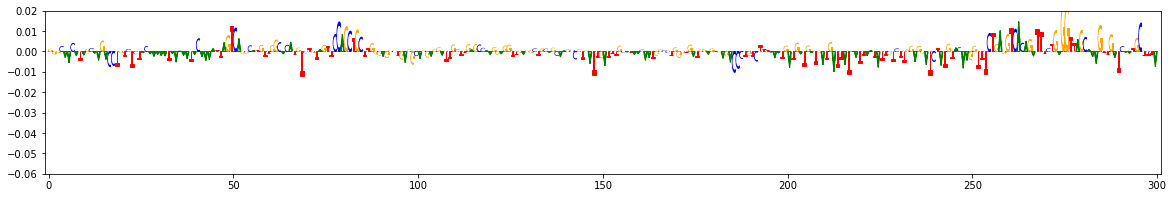

In [238]:
fig, ax= plt.subplots()
viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[2][1023:1323], subticks_frequency=50)
ax.set_ylim((-0.06,0.02))

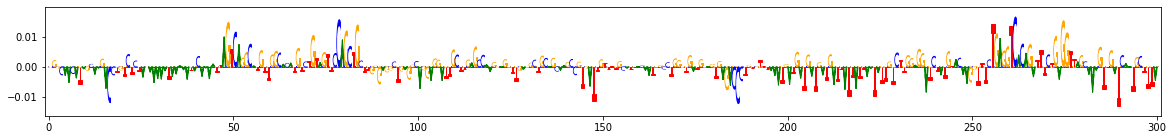

In [236]:
viz_sequence.plot_weights(projected_shap_scores[1][1023:1323], subticks_frequency=50)

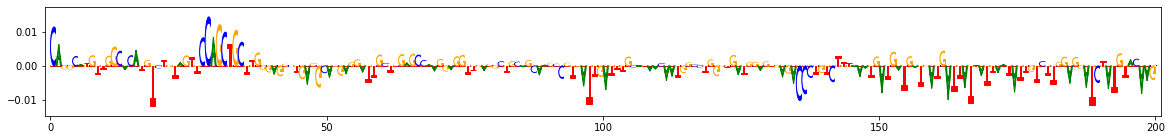

In [237]:
viz_sequence.plot_weights(projected_shap_scores[2][1073:1273], subticks_frequency=50)

## Peak Sets

In [34]:
peak_set = pd.read_csv("../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.bed", 
                           sep='\t',
                           names=["chr", "start", "end"])
peak_set["mid"] = (peak_set["start"] + peak_set["end"])//2
peak_set.head()

,chr,start,end,mid
0,chr1,839897,840397,840147
1,chr1,1801493,1802694,1802093
2,chr1,2118733,2119234,2118983
3,chr1,2349814,2350613,2350213
4,chr1,3803335,3803835,3803585


In [128]:
f = pyBigWig.open("/oak/stanford/groups/akundaje/surag/projects//scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx8.bw")
BATCH_SIZE = 128

# predict on raw sequence
raw_actual_counts = []

for i, r in tqdm.tqdm(peak_set.iterrows()):
    raw_actual_counts.append(np.log(np.nansum(f.values(r['chr'],r['mid']-(MODEL_OUT_LEN//2),r['mid']+(MODEL_OUT_LEN//2)))))
        
raw_actual_counts = np.array(raw_actual_counts)

f.close()

25712it [00:10, 2357.41it/s]


In [129]:
p10_c11_actual = deepcopy(raw_actual_counts)

In [98]:
p8_c11_actual = deepcopy(raw_actual_counts)

In [102]:
p11_c11_actual = deepcopy(raw_actual_counts)

In [103]:
np.median(p11_c11_actual)

5.638354669333745

In [130]:
np.median(p10_c11_actual)

4.882801922586371

In [105]:
np.median(p8_c11_actual)

3.970291913552122

In [94]:
p8_c4_actual = deepcopy(raw_actual_counts)

In [90]:
p11_c4_actual = deepcopy(raw_actual_counts)

In [95]:
np.median(p8_c4_actual)

4.3694478524670215

In [91]:
np.median(p11_c4_actual)

4.477336814478207

In [73]:
np.median(raw_actual_counts)

3.4011973816621555

In [21]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(peak_set.shape[0]/BATCH_SIZE))):
    cur_seqs = peak_set[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        cur_raw_seqs.append(str(hg38[r['chr']][r['mid']-(MODEL_INP_LEN//2):r['mid']+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 147/147 [01:46<00:00,  1.38it/s]


In [141]:
np.median(p10_cts)

4.083926

In [142]:
np.median(p11_cts)

4.266446

In [137]:
p10_cts = deepcopy(raw_pred_counts)

In [22]:
p11_cts = deepcopy(raw_pred_counts)

In [26]:
import sklearn

In [23]:
len(p11_cts)

18784

In [24]:
len(p8_cts)

22858

In [19]:
p8_cts = deepcopy(raw_pred_counts)

Text(0, 0.5, 'A (on removing ZEB motif)')

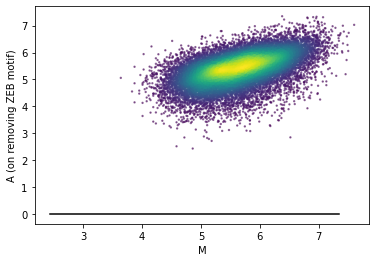

In [125]:
x = p11_c11_actual
y = p11_cts
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
plt.plot([min(raw_pred_counts), max(raw_pred_counts)], [0,0], '-k', label='y=2x+1')
plt.xlabel("M")
plt.ylabel("A (on removing ZEB motif)")

In [107]:
np.median(p11_cts)

5.3999386

In [133]:
np.median(p10_cts)

5.137354

In [49]:
np.median(p8_cts)

4.452514

In [62]:
# test set
print(np.median(np.array(p11_cts)[peak_set["chr"] =="chr1"]))
print(np.median(np.array(p8_cts)[p8["chr"] =="chr1"]))

5.3216825
4.3874273


(array([4.02969385e-04, 0.00000000e+00, 4.02969385e-04, 2.41781631e-03,
        0.00000000e+00, 2.01484692e-03, 4.02969385e-03, 3.62672446e-03,
        1.00742346e-02, 6.85047954e-03, 2.94167651e-02, 2.01484692e-02,
        5.88335301e-02, 9.34888972e-02, 1.12025489e-01, 1.38621468e-01,
        2.64750886e-01, 3.35270528e-01, 3.62269477e-01, 5.72216526e-01,
        5.83902638e-01, 5.96394689e-01, 7.46299300e-01, 7.96267504e-01,
        7.14867688e-01, 7.12852841e-01, 6.62884638e-01, 4.95652343e-01,
        4.73891996e-01, 3.49374456e-01, 3.10286426e-01, 2.20021284e-01,
        1.37412560e-01, 1.24114570e-01, 8.38176320e-02, 5.68186832e-02,
        3.74761528e-02, 2.21633162e-02, 1.85365917e-02, 1.20890815e-02,
        7.65641831e-03, 1.00742346e-02, 6.85047954e-03, 4.83563261e-03,
        4.02969385e-03, 1.20890815e-03, 8.05938769e-04, 8.05938769e-04,
        1.61187754e-03, 1.20890815e-03]),
 array([1.38629436, 1.49485933, 1.6034243 , 1.71198927, 1.82055424,
        1.92911921, 2.0376

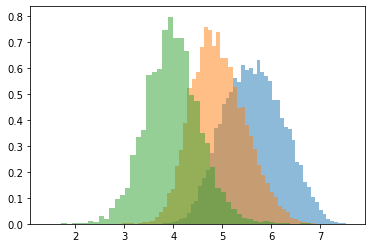

In [134]:
plt.hist(p11_c11_actual, bins=50, alpha=0.5, density=True)
plt.hist(p10_c11_actual, bins=50, alpha=0.5, density=True)
plt.hist(p8_c11_actual, bins=50, alpha=0.5, density=True)

(array([0.00086871, 0.00086871, 0.00086871, 0.00086871, 0.00173743,
        0.0030405 , 0.006081  , 0.00651535, 0.00781842, 0.01085891,
        0.01650555, 0.01520248, 0.0256271 , 0.02693011, 0.03561724,
        0.04734486, 0.05863813, 0.07601239, 0.09599279, 0.12248854,
        0.13769135, 0.17634875, 0.21978441, 0.25366422, 0.31230235,
        0.35921286, 0.38483989, 0.45042773, 0.52253091, 0.54729053,
        0.60940222, 0.667606  , 0.6545753 , 0.69149561, 0.64545381,
        0.60245252, 0.55901686, 0.47127684, 0.36399078, 0.26930105,
        0.19241995, 0.12943886, 0.07123447, 0.03474852, 0.0230209 ,
        0.01042456, 0.00347485, 0.00217178, 0.00217178, 0.00086871]),
 array([1.0170331, 1.117753 , 1.218473 , 1.3191928, 1.4199127, 1.5206326,
        1.6213526, 1.7220724, 1.8227923, 1.9235122, 2.0242321, 2.124952 ,
        2.225672 , 2.3263917, 2.4271116, 2.5278316, 2.6285515, 2.7292714,
        2.8299913, 2.9307113, 3.0314312, 3.132151 , 3.2328708, 3.3335907,
        3.4343107, 3.5

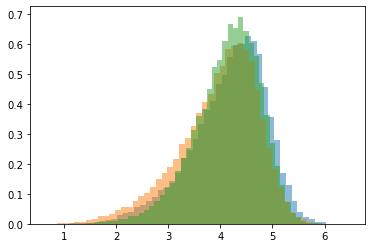

In [148]:
plt.hist(p11_cts, bins=50, alpha=0.5, density=True)
plt.hist(p10_cts, bins=50, alpha=0.5, density=True)
plt.hist(p8_cts, bins=50, alpha=0.5, density=True)

In [50]:
scipy.stats.ttest_ind(p8_cts, p11_cts)

Ttest_indResult(statistic=-142.79434913942248, pvalue=0.0)

## OCTSOX Saturation

Introduce OS consensus motif in random sequences. Then try for N=1..8 mutations in OS motif and measure how the predicted counts decreases with increasing mutations.

In [12]:
from random import shuffle, choice, random
from copy import deepcopy

In [13]:
random_positions = [(choice(["chr"+str(x) for x in range(1,23)]), int(random()*4e7)) for _ in range(128*1)]

In [14]:
# or choose from weak motif hits from a peak set
# random_positions = [(x["chr"],x["start"]) for _,x in oct_sox_hits.sample(128).iterrows()]

In [21]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts = []
random_pred_counts_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts.append(cur_pred)
    
    cur_pred = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts_neur.append(cur_pred)
    
random_pred_counts = np.vstack(random_pred_counts).ravel()
random_pred_counts_neur = np.vstack(random_pred_counts_neur).ravel()

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


In [22]:
def mod_sequence(s, rep, motif_start, motif_end):
    return s[:motif_start] + rep + s[motif_end:] #  + "CCACCC" + s[motif_end+26:motif_end+46] +\
#                               "CCACCC" + s[motif_end+52:motif_end+72]  +"CCACCC" +  s[motif_end+78:motif_end+100] + \
#                               "CCACCC" + s[motif_end+88:motif_end+108] +"ACAAAA" +  s[motif_end+114:motif_end+134] + \
#                               "ACAAAA" + s[motif_end+140:motif_end+160] +"TGACTCA" +  s[motif_end+167:motif_end+185] +\
#                                "TGACTCA" +  s[motif_end+192:] 

In [29]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []
synth_pred_counts_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 
        motif_end = MODEL_INP_LEN//2 + 15

        replacement = "ATTTGCATAACAATG"
        
        cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], replacement, motif_start, motif_end)
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
    cur_pred = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts_neur.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()
synth_pred_counts_neur = np.vstack(synth_pred_counts_neur).ravel()

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


In [30]:
np.median(random_pred_counts), np.median(random_pred_counts_neur)

(4.5397654, 1.9823403)

In [31]:
np.median(synth_pred_counts), np.median(synth_pred_counts_neur)

(5.3720956, 2.6649446)

In [55]:
def mut_str(s, n):
    assert(len(s)>=n)

    # choose n positions
    x = list(range(len(s)))
    shuffle(x)
    
    mod = list(s)
    for pos in x[:n]:
        cur_char = mod[pos]
        rep = choice([x for x in ["A","C", "G","T"] if x!=cur_char])
        mod[pos] = rep
    
    return ''.join(mod)

In [56]:
from collections import defaultdict

In [57]:
all_muts = defaultdict(list)

NUM_MUTS = 64
for i in range(1,8):
    for _ in range(NUM_MUTS):
        all_muts[i].append(mut_str("ATTTGCATAACAATG", i))

In [58]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_perturb_counts = []
synth_pred_perturb_counts_neur = []

for i in tqdm.tqdm(range(len(random_positions))):
    cur_seq = random_positions[i]
    cur_seq_out = []
    cur_seq_out_neur = []
    
    for j in range(1,8):
        cur_raw_seqs = []
            
        cur_seq_str = str(hg38[cur_seq[0]][cur_seq[1]-(MODEL_INP_LEN//2):cur_seq[1]+(MODEL_INP_LEN//2)])
        
        motif_start = MODEL_INP_LEN//2 
        motif_end = MODEL_INP_LEN//2 + 15

        for rep in all_muts[j]:
            cur_raw_seqs.append(mod_sequence(cur_seq_str, rep, motif_start, motif_end))
        
        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
        cur_pred = model.predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        cur_seq_out.append(cur_pred)
        
        cur_pred = model_neur.predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        cur_seq_out_neur.append(cur_pred)
        
    synth_pred_perturb_counts.append(cur_seq_out)
    synth_pred_perturb_counts_neur.append(cur_seq_out_neur)

100%|██████████| 128/128 [09:42<00:00,  4.55s/it]


In [62]:
mean_perturb = [[synth_pred_counts[i]]+[np.mean(y) for y in x] for i,x in enumerate(synth_pred_perturb_counts)]
mean_perturb_norm = [(x-np.min(x))/(np.max(x)-np.min(x)) for x in mean_perturb]

mean_perturb_neur = [[synth_pred_counts_neur[i]]+[np.mean(y) for y in x] for i,x in enumerate(synth_pred_perturb_counts_neur)]
mean_perturb_norm_neur = [(x-np.min(x))/(np.max(x)-np.min(x)) for x in mean_perturb_neur]

In [63]:
summarized_trend = np.mean(np.array(mean_perturb_norm), axis=0)
summarized_trend_norm = (summarized_trend-np.min(summarized_trend))/(np.max(summarized_trend)-np.min(summarized_trend))

summarized_trend_neur = np.mean(np.array(mean_perturb_norm_neur), axis=0)
summarized_trend_norm_neur = (summarized_trend_neur-np.min(summarized_trend_neur))/(np.max(summarized_trend_neur)-np.min(summarized_trend_neur))

In [64]:
# summarized_trend_norm_m4 = deepcopy(summarized_trend_norm)

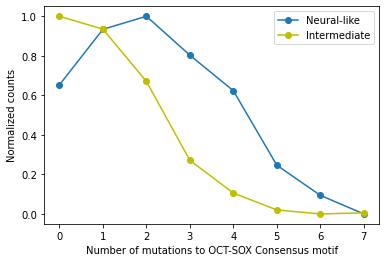

In [65]:
plt.plot(range(8), summarized_trend_norm_neur, 'o-', label="Neural-like", )
plt.plot(range(8), summarized_trend_norm, 'o-', c='y', label="Intermediate", )
# plt.plot(range(8), summarized_trend_norm_m16, c='r', label="iPSC")
plt.xlabel("Number of mutations to OCT-SOX Consensus motif")
plt.ylabel("Normalized counts")
plt.legend()

In [435]:
IDX = 0
print(synth_pred_counts_neur[IDX])
print([synth_pred_perturb_counts_neur[IDX][i][0][0] for i in range(7)])

4.237163
[4.6754713, 4.4134855, 4.448343, 3.9454129, 3.747013, 3.3897176, 3.5638669]


In [461]:
IDX = 20
cur_raw_seqs = []

cur_seq = random_positions[IDX]
print(random_positions[IDX])
cur_seq_str = str(hg38[cur_seq[0]][cur_seq[1]-(MODEL_INP_LEN//2):cur_seq[1]+(MODEL_INP_LEN//2)])

motif_start = MODEL_INP_LEN//2 
motif_end = MODEL_INP_LEN//2 + 15

cur_raw_seqs.append(mod_sequence(cur_seq_str, "ATTTGCATAACAATG", motif_start, motif_end))

for j in range(1,8):
    cur_raw_seqs.append(mod_sequence(cur_seq_str, all_muts[j][0], motif_start, motif_end))

cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
cur_raw_seqs.shape

('chr6', 143096314)


(8, 2346, 4)

In [462]:
cur_cts = model_neur.predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])[1].ravel()

print(cur_cts)

print([synth_pred_counts_neur[IDX]] + [synth_pred_perturb_counts_neur[IDX][i][0][0] for i in range(7)])

[4.1661596 4.314418  4.40882   4.1910954 4.1981363 3.709177  3.7691166
 3.84324  ]
[4.1661596, 4.297318, 4.234083, 4.212667, 3.8571491, 3.9620585, 3.8594239, 3.8557563]


In [463]:
X = cur_raw_seqs
counts_shap_scores_neur = profile_model_counts_explainer_neur.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
counts_shap_scores_neur = np.multiply(X, counts_shap_scores_neur[0])

Done 0 examples of 8


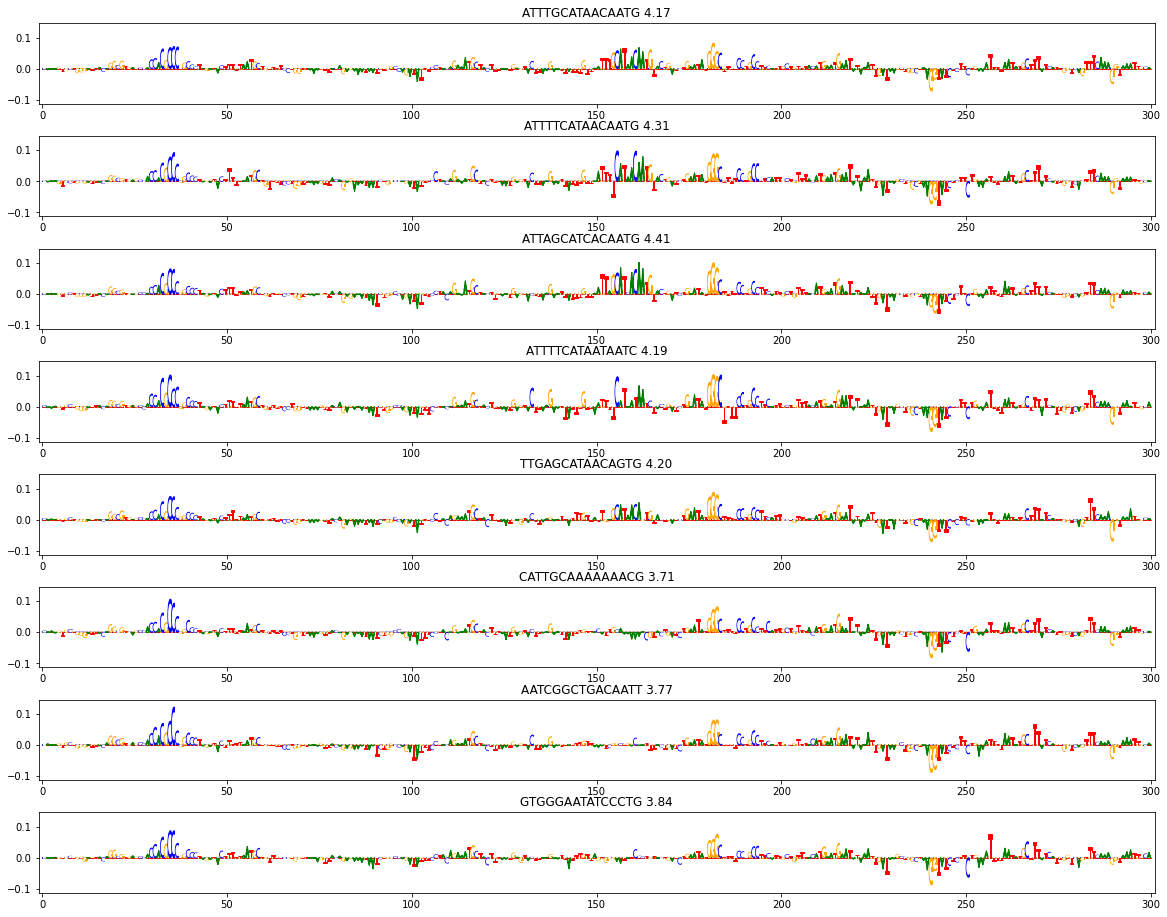

In [464]:
fig, axs = plt.subplots(counts_shap_scores_neur.shape[0],1, figsize=(20,2*counts_shap_scores_neur.shape[0]))

start = MODEL_INP_LEN//2 - 150
end = MODEL_INP_LEN//2 + 150

l, u = 0,0
for i in range(counts_shap_scores_neur.shape[0]):
    viz_sequence.plot_weights_given_ax(axs[i], 
                                       counts_shap_scores_neur[i][start:end], 
                                       subticks_frequency=50)
    
    if i==0:
        axs[0].set_title("ATTTGCATAACAATG {:.2f}".format(cur_cts[i]))
    else:
        axs[i].set_title("{} {:.2f}".format(all_muts[i][0], cur_cts[i]))
    
    l_,u_ = axs[i].get_ylim()
    if l_ < l:
        l = l_
    if u_ > u:
        u = u_
    
for i in range(counts_shap_scores_neur.shape[0]):
    axs[i].set_ylim((l,u))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
# plt.savefig("snippets/{}.pdf".format(ctr))
# ctr+=1